# Importação de Pacotes

In [1]:
#leitura da base de dados
import pandas as pd
from pathlib import Path

#modelo preditivo escolhido
from sklearn import tree

#validação cruzada
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
import numpy as np

#métricas
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, ConfusionMatrixDisplay

#pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

In [2]:
def estimadores(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(
        ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test)
    )

    print(f"""
      Acurária: {round(acuracia,3)};
      Revocação: {round(recall,3)};
      F1: {round(F1,3)};
      Roc_Auc: {round(roc_auc,3)}""")

## Leitura DataFrame

In [ ]:
direcao = Path("../..") / "data"
caminho = direcao / "df_tcu.csv"

df = pd.read_csv(caminho)

### Escolha do Modelo

In [4]:
modelo= tree.DecisionTreeClassifier()

### Escolha dos HiperParâmetros

In [5]:
parametros = {
    "modelo__max_depth": range(1, 5),
    "modelo__min_samples_split": range(2, 10),
    "modelo__min_samples_leaf": range(1, 10)
}

# Aplicação de Pipelines

In [6]:
#transformando coluna númerica em float64 (no df original encontra-se como str)
def numerico(coluna):
    return(pd.to_numeric(coluna.squeeze(), errors="coerce").to_frame())

X = df[["materialidade_valor_envolvido", "categoria_de_proposta"]]
y = df["admissibilidade_concedida"].replace({0: 1, 1: 0})

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=22)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', FunctionTransformer(numerico), ["materialidade_valor_envolvido"]),
        ('cat', OneHotEncoder(drop="first", sparse_output=False), ["categoria_de_proposta"])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('modelo', modelo)
    ])

searchCV_pipeline = RandomizedSearchCV(
    pipeline,
    parametros,
    scoring='roc_auc',
    refit='roc_auc',
    cv=5
)

searchCV_pipeline.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'modelo__max_depth': range(1, 5), 'modelo__min_samples_leaf': range(1, 10), 'modelo__min_samples_split': range(2, 10)}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,None
,refit,'roc_auc'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan



      Acurária: 0.857;
      Revocação: 0.083;
      F1: 0.148;
      Roc_Auc: 0.538


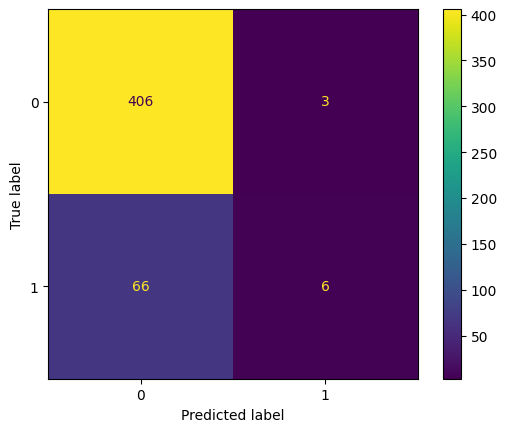

In [7]:
estimadores(searchCV_pipeline, X_test, y_test)